In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Session 20c: 

## LSTM - Weather data


<img src='../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
# Lets import some libraries
import os

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf

%matplotlib inline

2023-12-04 13:33:38.295955: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-04 13:33:38.394401: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 13:33:38.394447: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 13:33:38.395814: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-04 13:33:38.405293: I tensorflow/core/platform/cpu_feature_guar

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
# Strictly for tensorflow version 2.12
### To hide bugs throwing warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [5]:
# Some basic parameters

inpDir = '../../input' # location where input data is stored
outDir = '../output' # location to store outputs

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible results

EPOCHS = 50  # number of cycles to run

ALPHA = 0.001  # learning rate

TEST_SIZE = 0.2 # What fraction we want to keep for testing

BATCH_SIZE = 32

LR_PATIENCE = 2

FACTOR_LR = 0.5

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (12,9),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }
CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

## Helper Function

In [6]:
def fn_plot_label(train_df : pd.DataFrame , test_df : pd.DataFrame):
    
    plt.figure(figsize=(15,5))
    
    plt.subplot(1,2,1)
    
    ax = train_df['label'].value_counts().plot(kind='bar',
                                              title='Training distribution',
                                              color='DarkBlue',alpha=0.8)
    
    plt.subplot(1,2,2)
     
    ax = test_df['label'].value_counts().plot(kind='bar',
                                              title='Testing distribution',
                                              color='Orange',alpha=0.8)
    

In [7]:
train_df = pd.read_csv('fashion-mnist_train.csv')
test_df = pd.read_csv('fashion-mnist_test.csv')

In [8]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
class_label = {0: "T-shirt/top",
              1:'Trouser',
              2:'Pullover',
              3:'Dress',
              4:'Coat',
              5:'Sandal',
              6:'Shirt',
              7:'Sneaker',
              8:'Bag',
              9:'Ankle boot'}

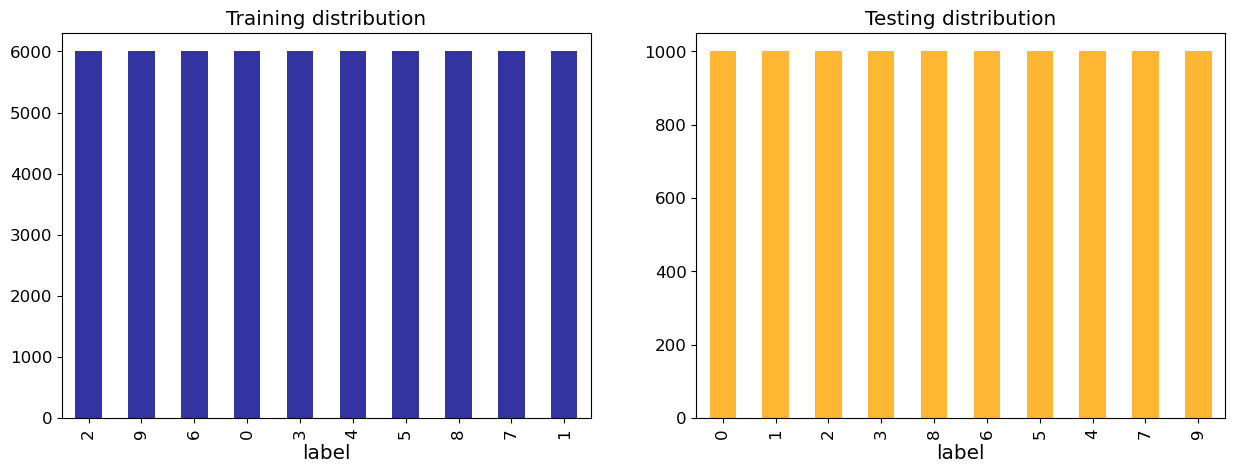

In [11]:
fn_plot_label(train_df,test_df)

In [12]:
### Converting to Dataset

In [13]:
def fn_split_features_labels(row):
    
    features = tf.reshape(row[1:],[28,28,1])
    
    label = row[0]
    
    return features,label
    

In [14]:
# Train Data

tmp_ds = tf.data.Dataset.from_tensor_slices(train_df)

train_ds = tmp_ds.map(fn_split_features_labels)

train_ds = train_ds.batch(BATCH_SIZE)


# Test Data

tmp_ds = tf.data.Dataset.from_tensor_slices(test_df)

test_ds = tmp_ds.map(fn_split_features_labels)

test_ds = test_ds.batch(BATCH_SIZE)

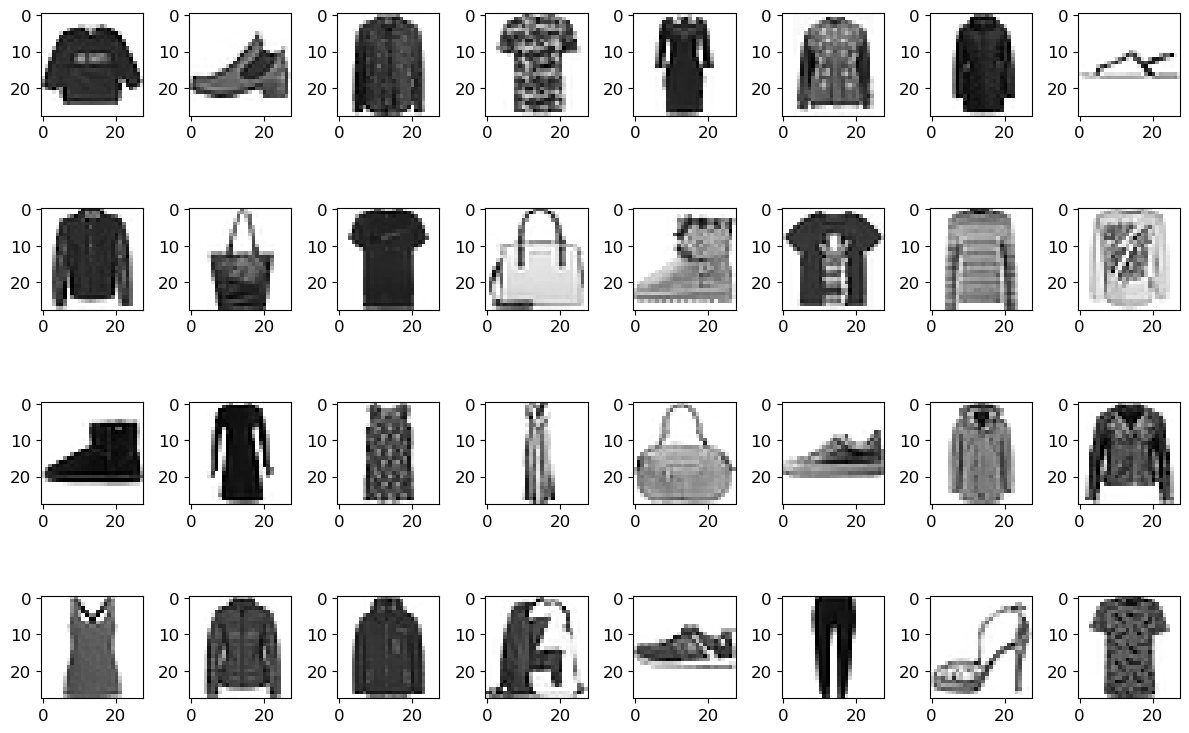

In [15]:
for images, labels in train_ds.take(1):
    #print(images.shape,labels)
    
    for i in range(BATCH_SIZE):

        rows = 4
        plt.subplot(4,BATCH_SIZE//rows,i+1)

        plt.imshow(images[i].numpy().astype('uint8'), cmap=plt.cm.binary)
        plt.grid(False)
        plt.tight_layout()

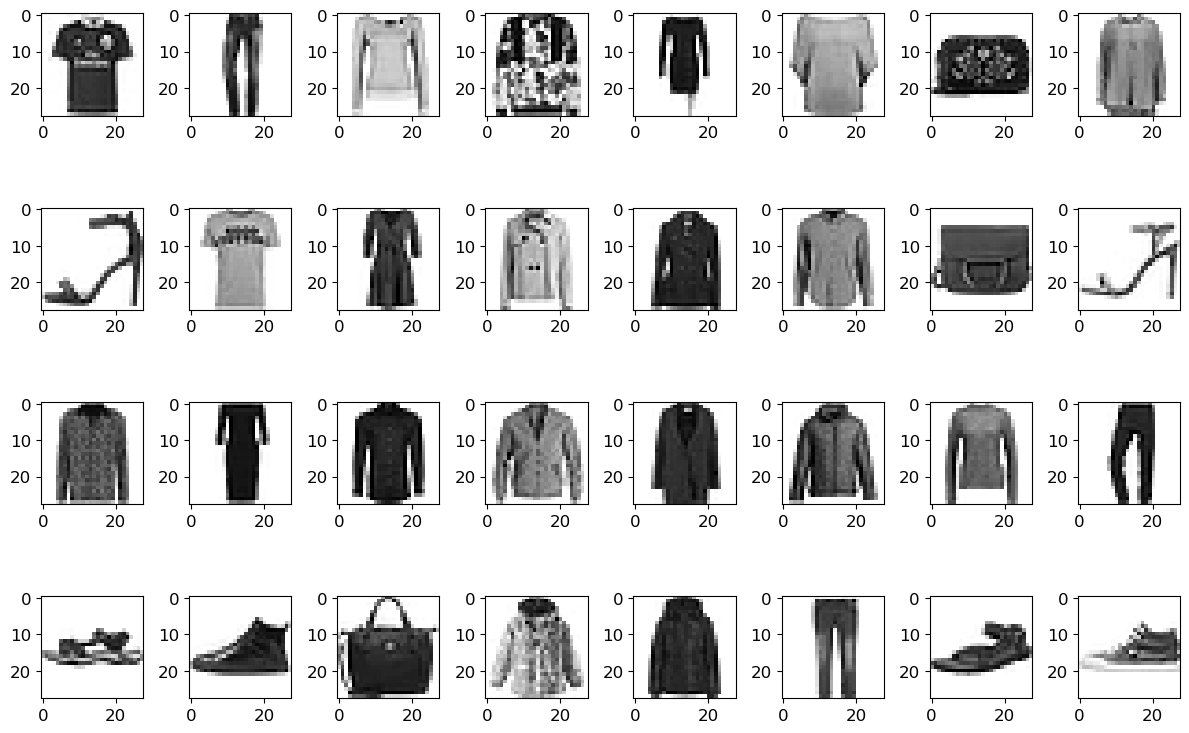

In [16]:
for images, labels in test_ds.take(1):
    #print(images.shape,labels)
    
    for i in range(BATCH_SIZE):

        rows = 4
        plt.subplot(4,BATCH_SIZE//rows,i+1)

        plt.imshow(images[i].numpy().astype('uint8'), cmap=plt.cm.binary)
        plt.grid(False)
        plt.tight_layout()

In [17]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
# images[0]
l2 = tf.keras.regularizers.l2(l2=0.01)

In [19]:
dor1 = 0.5
dor2 = 0.4
dor3 = 0.3
dor4 = 0.2
dor5 = 0.1

In [23]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Rescaling(1/255), # 28 28 3 
    
    # -----------------------
    # Set 1 
    # -----------------------
    
    tf.keras.layers.Conv2D(32,(3,3),
                          padding='same',
                          activation='relu',
                          input_shape= (28,28,1),
                          kernel_regularizer=l2), # 28 28 32
    
    # Pooling 
    tf.keras.layers.MaxPooling2D( (2,2) ), # 14 14 32 

    tf.keras.layers.Dropout(rate = dor1),
    
    # -----------------------
    # Set 2 
    # -----------------------
    tf.keras.layers.Conv2D(64,(3,3),
                          activation='relu',
                          kernel_regularizer=l2), # 12 12 64
    # Pooling 
    tf.keras.layers.MaxPooling2D( (2,2) ), # 6 6 64 
    
    tf.keras.layers.Dropout(rate = dor2),
    # -----------------------
    # Set 3
    # -----------------------
    
    # Conv 3 
    tf.keras.layers.Conv2D(128,(3,3),
                           kernel_regularizer=l2,
                          activation='relu'), # 4 4 128
    tf.keras.layers.Dropout(rate = dor3),
    
    tf.keras.layers.Flatten(),
    # -----------------------
    # ANN 
    # -----------------------
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate = dor4),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dropout(rate = dor5),
 
])

In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='val_loss',
    min_delta=0,
    patience=LR_PATIENCE,
    verbose=1,
    restore_best_weights=True,
    baseline=None
)

lr_decay = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=FACTOR_LR,
    patience=LR_PATIENCE,
    verbose=1,
    mode='auto'
)

In [25]:
optim = tf.keras.optimizers.Adam(learning_rate = ALPHA)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optim,loss=loss_fn,metrics=['accuracy'])

In [26]:
history = model.fit(train_ds,
                    validation_data=test_ds,
                   epochs=EPOCHS,
                   verbose=1,
                   batch_size = BATCH_SIZE,
                   callbacks=[early_stopping,lr_decay])

Epoch 1/50
1875/1875 [==============================] - 52s 27ms/step - loss: 0.9326 - accuracy: 0.7188 - val_loss: 0.5951 - val_accuracy: 0.8361 - lr: 0.0010
Epoch 2/50
1875/1875 [==============================] - 48s 25ms/step - loss: 0.7174 - accuracy: 0.7773 - val_loss: 0.5449 - val_accuracy: 0.8504 - lr: 0.0010
Epoch 3/50
1875/1875 [==============================] - 47s 25ms/step - loss: 0.6844 - accuracy: 0.7898 - val_loss: 0.5103 - val_accuracy: 0.8609 - lr: 0.0010
Epoch 4/50
1875/1875 [==============================] - 48s 25ms/step - loss: 0.6588 - accuracy: 0.7960 - val_loss: 0.4963 - val_accuracy: 0.8701 - lr: 0.0010
Epoch 5/50
1875/1875 [==============================] - 47s 25ms/step - loss: 0.6499 - accuracy: 0.7999 - val_loss: 0.4833 - val_accuracy: 0.8683 - lr: 0.0010
Epoch 6/50
1875/1875 [==============================] - 47s 25ms/step - loss: 0.6398 - accuracy: 0.8063 - val_loss: 0.4722 - val_accuracy: 0.8741 - lr: 0.0010
Epoch 7/50
1875/1875 [========================

In [27]:
### Function to plot Loss Curve
###-----------------------------------

def plot_tf_hist(hist_df):
    '''
    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
   
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
   
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
   
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
   
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
   
   
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
   
    plt.tight_layout()

In [ ]:
res_df = pd.DataFrame(history)
res_df.plot()